**Thêm thư viện cần thiết**

In [1]:
import tensorflow as tf

# Cấu hình TensorFlow sử dụng GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Giới hạn bộ nhớ GPU tránh chiếm hết
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPUs are ready for TensorFlow.")
    except RuntimeError as e:
        print(e)


GPUs are ready for TensorFlow.


In [2]:
# Thêm thư viện
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
import re
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers import Bidirectional
from keras.layers import Add
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image as keras_image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.image as mpimg
from tqdm import tqdm
from tensorflow.keras.layers import (
    Dropout, MultiHeadAttention, Add, LayerNormalization
)
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.layers import Lambda, Input

**Chuẩn bị dữ liệu**

In [3]:
# Đường dẫn tới file CSV
csv_path = "/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv"
image_dir = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/"

# Đọc file CSV
data = pd.read_csv(csv_path, delimiter='|', names=['image_name', 'comment_number', 'comment'], skiprows=1)
data['comment'] = data['comment'].fillna('')

# Làm sạch và chuẩn bị từ điển ảnh-mô tả
image_map = {}
def clean_text(sentence):
    sentence = sentence.lower()
    # Làm sạch câu
    cleaned = re.sub(r"[^a-zA-Z0-9.,\s]", "", sentence)
    # Tách câu thành danh sách từ
    words = cleaned.split()
    # Nếu câu mô tả có số từ lớn hơn 48 -> chỉ giữ lại 48 từ đầu tiên
    if len(words) > 48:
        cleaned = " ".join(words[:48])
    return cleaned

for _, row in data.iterrows():
    image_name = row['image_name'].strip()
    comment = row['comment'].strip()
    comment = clean_text(comment)
    comment = f"start {comment} end" 
    if image_name not in image_map:
        image_map[image_name] = []
    image_map[image_name].append(comment)
    
# Kiểm tra kết quả
print(f"Số lượng ảnh: {len(image_map)}")
for image, comments in list(image_map.items())[:3]:  # Hiển thị bình luận của 3 ảnh đầu tiên
    print(f"\nẢnh: {image}")
    print("Bình luận:")
    print(comments)

Số lượng ảnh: 31783

Ảnh: 1000092795.jpg
Bình luận:
['start two young guys with shaggy hair look at their hands while hanging out in the yard . end', 'start two young , white males are outside near many bushes . end', 'start two men in green shirts are standing in a yard . end', 'start a man in a blue shirt standing in a garden . end', 'start two friends enjoy time spent together . end']

Ảnh: 10002456.jpg
Bình luận:
['start several men in hard hats are operating a giant pulley system . end', 'start workers look down from up above on a piece of equipment . end', 'start two men working on a machine wearing hard hats . end', 'start four men on top of a tall structure . end', 'start three men on a large rig . end']

Ảnh: 1000268201.jpg
Bình luận:
['start a child in a pink dress is climbing up a set of stairs in an entry way . end', 'start a little girl in a pink dress going into a wooden cabin . end', 'start a little girl climbing the stairs to her playhouse . end', 'start a little girl c


Ảnh: 1000092795.jpg


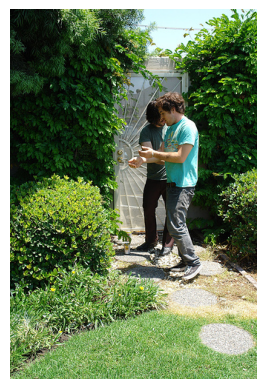

Bình luận:
['start two young guys with shaggy hair look at their hands while hanging out in the yard . end', 'start two young , white males are outside near many bushes . end', 'start two men in green shirts are standing in a yard . end', 'start a man in a blue shirt standing in a garden . end', 'start two friends enjoy time spent together . end']

Ảnh: 10002456.jpg


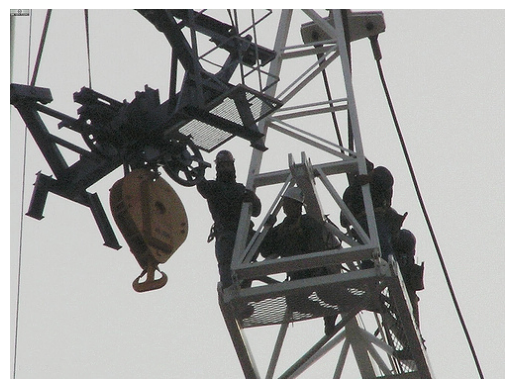

Bình luận:
['start several men in hard hats are operating a giant pulley system . end', 'start workers look down from up above on a piece of equipment . end', 'start two men working on a machine wearing hard hats . end', 'start four men on top of a tall structure . end', 'start three men on a large rig . end']


In [4]:
# Đường dẫn thư mục chứa ảnh
image_dir = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/"

# Hiển thị ảnh từ image_map
for image_name, comments in list(image_map.items())[:2]:  # Hiển thị 2 ảnh đầu tiên
    # Tạo đường dẫn đầy đủ đến ảnh
    image_path = image_dir + image_name
    print(f"\nẢnh: {image_name}")
    
    # Đọc và hiển thị ảnh
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Tắt hiển thị trục
    plt.show()
    
    print("Bình luận:")
    print(comments)

In [6]:
# Chia tập train, val, test
total_images = len(image_map)
val_size = int(total_images * 0.15)
test_size = int(total_images * 0.01)
train_size = total_images - val_size - test_size

sorted_image_names = sorted(image_map.keys())
train_images = sorted_image_names[:train_size]
val_images = sorted_image_names[train_size:train_size + val_size]
test_images = sorted_image_names[train_size + val_size:]

train_map = {img: image_map[img] for img in train_images}
val_map = {img: image_map[img] for img in val_images}
test_map = {img: image_map[img] for img in test_images}

print(f"Tập train: {len(train_map)} ảnh")
print(f"Tập val: {len(val_map)} ảnh")
print(f"Tập test: {len(test_map)} ảnh")

Tập train: 26699 ảnh
Tập val: 4767 ảnh
Tập test: 317 ảnh


**Xử lý ảnh với mô hình Resnet152**

In [7]:
from keras.applications.resnet import ResNet152, preprocess_input

# Load mô hình ResNet152
model_resnet = ResNet152(weights='imagenet', include_top=False, pooling='avg')  # Dùng 'avg' pooling để lấy đầu ra feature vector

# Hàm tiền xử lý hình ảnh
def preprocess_batch(image_paths):
    images = []
    for img_path in image_paths:
        img = keras_image.load_img(img_path, target_size=(224, 224))  # ResNet yêu cầu đầu vào 224x224
        x = keras_image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        images.append(x)
    return np.vstack(images)

# Hàm encode batch hình ảnh
def encode_batch(image_paths, model):
    preprocessed_images = preprocess_batch(image_paths)
    features = model.predict(preprocessed_images, verbose=0)
    return features

batch_size = 1024
# Encode training set
print("Encoding training images with ResNet152...")
encoding_image_train = {}
image_paths_train = [image_dir + str(img) for img in train_map.keys()]
for i in tqdm(range(0, len(image_paths_train), batch_size), desc="Processing Train"):
    batch_paths = image_paths_train[i:i + batch_size]
    batch_features = encode_batch(batch_paths, model_resnet)
    for j, img in enumerate(batch_paths):
        img_name = img.split("/")[-1]
        encoding_image_train[img_name] = batch_features[j]

# Encode validation set
print("Encoding validation images with ResNet152...")
encoding_image_val = {}
image_paths_val = [image_dir + str(img) for img in val_map.keys()]
for i in tqdm(range(0, len(image_paths_val), batch_size), desc="Processing Validation"):
    batch_paths = image_paths_val[i:i + batch_size]
    batch_features = encode_batch(batch_paths, model_resnet)
    for j, img in enumerate(batch_paths):
        img_name = img.split("/")[-1]
        encoding_image_val[img_name] = batch_features[j]

# Encode test set
print("Encoding test images with ResNet152...")
encoding_image_test = {}
image_paths_test = [image_dir + str(img) for img in test_map.keys()]
for i in tqdm(range(0, len(image_paths_test), batch_size), desc="Processing Test"):
    batch_paths = image_paths_test[i:i + batch_size]
    batch_features = encode_batch(batch_paths, model_resnet)
    for j, img in enumerate(batch_paths):
        img_name = img.split("/")[-1]
        encoding_image_test[img_name] = batch_features[j]

print("Encoding completed for train, validation, and test sets!")


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Encoding training images with ResNet152...


Processing Train:   0%|          | 0/27 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1734689854.136927     100 service.cc:145] XLA service 0x7ae7c81c6ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734689854.136983     100 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734689859.727563     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Processing Train: 100%|██████████| 27/27 [08:16<00:00, 18.40s/it]


Encoding validation images with ResNet152...


Processing Validation: 100%|██████████| 5/5 [01:31<00:00, 18.25s/it]


Encoding test images with ResNet152...


Processing Test: 100%|██████████| 1/1 [00:09<00:00,  9.90s/it]

Encoding completed for train, validation, and test sets!


**Lưu lại file econder của ảnh**

In [8]:
print("Ví dụ Ecoding cho 1 ảnh Train: ",list(encoding_image_train.keys())[0])
print(list(encoding_image_train.values())[0])

print("Ví dụ Ecoding cho 1 ảnh val:",list(encoding_image_val.keys())[0])
print(list(encoding_image_val.values())[0])

print("Ví dụ Ecoding cho 1 ảnh Test:",list(encoding_image_test.keys())[0])
print(list(encoding_image_test.values())[0])

# Đường dẫn thư mục
pickle_dir = "/kaggle/working/Pickle"

# Kiểm tra và tạo thư mục nếu chưa tồn tại
os.makedirs(pickle_dir, exist_ok=True)

# Lưu image embedding lại
with open(os.path.join(pickle_dir, "encoded_train_images.pkl"), "wb") as encoded_pickle:
    dump(encoding_image_train, encoded_pickle)
    
# Lưu image embedding lại
with open(os.path.join(pickle_dir, "encoded_val_images.pkl"), "wb") as encoded_pickle:
    dump(encoding_image_val, encoded_pickle)

# Lưu image embedding lại
with open(os.path.join(pickle_dir, "encoded_test_images.pkl"), "wb") as encoded_pickle:
    dump(encoding_image_test, encoded_pickle)

model_resnet.save('/kaggle/working/resnet152_feature_extractor.h5')

Ví dụ Ecoding cho 1 ảnh Train:  1000092795.jpg
[0.11620455 0.37208065 4.2619205  ... 0.0916837  0.17356716 0.        ]
Ví dụ Ecoding cho 1 ảnh val: 532457586.jpg
[0.48527783 0.         0.99230117 ... 1.2942067  1.4134915  1.1091354 ]
Ví dụ Ecoding cho 1 ảnh Test: 868984478.jpg
[0.         0.40695688 1.6262015  ... 0.05247079 1.3485469  0.4912564 ]


**Tải encoding ảnh, xử lý cho all mô tả (chỉ giữ lại những từ mà xuất hiện trên 2 lần trong số tất cả các mô tả)**

In [9]:
train_features = load(open("/kaggle/working/Pickle/encoded_train_images.pkl", "rb"))
print('Số lượng vecto encoding ảnh train = %d\n' % len(train_features))
val_features = load(open("/kaggle/working/Pickle/encoded_val_images.pkl", "rb"))
print('Số lượng vecto encoding ảnh val = %d\n' % len(val_features))
test_features = load(open("/kaggle/working/Pickle/encoded_test_images.pkl", "rb"))
print('Số lượng vecto encoding ảnh test = %d\n' % len(test_features))

# Tạo list các training caption
all_train_captions = []  
for key, val in image_map.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)
print("5 mô tả đầu tiên của tất cả mô tả: ",all_train_captions[:5])
# Chỉ lấy các từ xuất hiện trên 2 lần
word_count_threshold = 2
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('\nXử lý từ %d từ vựng -> xuống còn %d từ vựng\n' % (len(word_counts), len(vocab)))
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
    
# print("Danh sách từ điển từ: ",wordtoix)
# print("Từ điển từ",ixtoword) 
vocab_size = len(ixtoword) + 1 # Thêm 1 cho từ dùng để padding
print("\nVocab_size= ",vocab_size)

# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_map)
print('\nĐộ dài lớn nhất của một mô tả: %d' % max_length)

Số lượng vecto encoding ảnh train = 26699

Số lượng vecto encoding ảnh val = 4767

Số lượng vecto encoding ảnh test = 317

5 mô tả đầu tiên của tất cả mô tả:  ['start two young guys with shaggy hair look at their hands while hanging out in the yard . end', 'start two young , white males are outside near many bushes . end', 'start two men in green shirts are standing in a yard . end', 'start a man in a blue shirt standing in a garden . end', 'start two friends enjoy time spent together . end']

Xử lý từ 20056 từ vựng -> xuống còn 12484 từ vựng


Vocab_size=  12485

Độ dài lớn nhất của một mô tả: 50


In [9]:
import pickle

# Lưu từ điển wordtoix vào file
with open('/kaggle/working/Pickle/wordtoix.pkl', 'wb') as f:
    pickle.dump(wordtoix, f)

# Lưu từ điển ixtoword vào file
with open('/kaggle/working/Pickle/ixtoword.pkl', 'wb') as f:
    pickle.dump(ixtoword, f)

print("Đã lưu thành công wordtoix và ixtoword.")


Đã lưu thành công wordtoix và ixtoword.


**Xử lý embeddings cho chuỗi text mô tả sử dụng word embedding Glove model**

In [10]:
# Load Glove model
glove_dir = '/kaggle/input/glove6b'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))
embeddings_index['the']

embedding_dim = 300

# Get 300-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():  # duyệt trong từ điển từ
    #if i < max_words:
    embedding_vector = embeddings_index.get(word) # embecdding cho từ đó 
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
print("\nCấu hình của ma trận vecto embedding cho từ điển từ:",embedding_matrix.shape)

print('\nVí dụ từ thứ nhất: ',list(wordtoix.keys())[1])
print('Ma trận embedding: ',embedding_matrix[1])

print('\nVí dụ từ thứ hai: ',list(wordtoix.keys())[2])
print('Ma trận embedding: ',embedding_matrix[2])

Found 400000 word vectors.

Cấu hình của ma trận vecto embedding cho từ điển từ: (12485, 300)

Ví dụ từ thứ nhất:  two
Ma trận embedding:  [ 2.54000008e-01  3.01470011e-01  1.42729998e-01  1.68789998e-01
  4.95770015e-02  1.94069996e-01 -3.56959999e-01  2.77420014e-01
  3.53549987e-01 -1.32350004e+00  7.96609968e-02  1.06349997e-01
 -6.84290007e-02 -2.22750008e-02 -2.42219999e-01  9.01470035e-02
  2.87169993e-01 -7.86150023e-02  3.81999999e-01  2.24509999e-01
 -1.58999994e-01 -1.07210003e-01  9.39219967e-02 -5.56450002e-02
  2.57739991e-01 -3.48210007e-01  4.38910007e-01 -4.19409990e-01
 -1.43240005e-01  2.71429997e-02  5.18609993e-02  1.58280000e-01
  2.58929998e-01  2.96149999e-02 -1.53419995e+00  2.92149991e-01
 -5.45400023e-01  1.36649996e-01 -5.60869984e-02  5.29070012e-02
  1.29950002e-01  9.77459997e-02 -5.33079989e-02 -1.44529998e-01
 -1.74860001e-01 -2.62050003e-01  2.13550008e-03  4.98659998e-01
 -7.20610023e-02 -1.20499998e-01  5.33169985e-01 -1.43069997e-01
 -1.58069998e-01

**Hàm xử lý huấn luyện mô hình**

In [11]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = [], [], []
    n = 0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key]
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            
            if n == num_photos_per_batch:
                yield ((np.array(X1), np.array(X2)), np.array(y))  
                X1, X2, y = [], [], []
                n = 0

**Cấu tạo của mô hình**

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, GRU, Concatenate, Add, Lambda, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import pad_sequences, to_categorical
import tensorflow as tf

class ImageCaptioningModel:
    def __init__(self, vocab_size, embedding_dim, max_length):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_length = max_length
        self.model = self._build_model()

    def _build_model(self):
        # Tạo đầu vào cho đặc trưng ảnh
        inputs1 = Input(shape=(2048,), name="image_features")  # Đặc trưng ảnh từ ResNet152
        fe1 = Dropout(0.3)(inputs1)
        fe2 = Dense(256, activation='relu')(fe1)  # Lớp Dense cho ảnh

        # Tạo đầu vào cho caption
        inputs2 = Input(shape=(self.max_length,), name="text_input")  # Dữ liệu caption đầu vào
        se1 = Embedding(self.vocab_size, self.embedding_dim, mask_zero=True)(inputs2)  # Lớp embedding cho caption
        se2 = Dropout(0.3)(se1)

        # Multi-Head Attention cho caption
        attn_text = MultiHeadAttention(num_heads=4, key_dim=self.embedding_dim)(se2, se2)
        attn_text = Add()([se2, attn_text])  # Residual Connection
        attn_text = LayerNormalization()(attn_text)  # Layer Normalization
        se3 = GRU(256, return_sequences=True, recurrent_activation='sigmoid')(attn_text)  # GRU cho caption

        # Attention giữa đặc trưng ảnh và caption
        # fe2_expanded = Lambda(lambda x: tf.expand_dims(x, axis=1), output_shape=(1, 256))(fe2)  # (None, 1, 256)
        fe2_expanded = Lambda(lambda x: tf.expand_dims(x, axis=1))(fe2)  # (None, 1, 256)
        attn_image_text = MultiHeadAttention(num_heads=4, key_dim=128)(fe2_expanded, se3)
        attn_image_text = Add()([se3, attn_image_text])  # Residual Connection
        attn_image_text = LayerNormalization()(attn_image_text)

        # Gộp thông tin từ chuỗi văn bản
        pooled_text = GlobalAveragePooling1D()(attn_image_text)  # (None, 256)

        # Kết hợp đặc trưng ảnh và văn bản
        merged = Concatenate()([fe2, pooled_text])  # (None, 512)

        # Dự đoán từ tiếp theo
        decoder = Dense(256, activation='relu')(merged)
        outputs = Dense(self.vocab_size, activation='softmax', name="output")(decoder)  # (None, vocab_size)

        # Định nghĩa mô hình
        model = Model(inputs=[inputs1, inputs2], outputs=outputs)

        # Biên dịch mô hình
        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00005), metrics=['accuracy'])

        return model

    def summary(self):
        return self.model.summary()

**Khởi tạo mô hình**

In [ ]:
epochs = 30
number_pics_per_batch = 32
steps = len(train_map)//number_pics_per_batch    
# Tạo generator cho train
train_generator =data_generator(train_map, train_features, wordtoix, max_length, number_pics_per_batch)
# Tạo generator cho validation
val_generator = data_generator(val_map, val_features, wordtoix, max_length, number_pics_per_batch)
# Tạo generator cho validation
test_generator = data_generator(test_map, test_features, wordtoix, max_length, number_pics_per_batch)
# khởi tạo mô hình
caption_model = ImageCaptioningModel(vocab_size, embedding_dim, max_length)
caption_model.summary()

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Tạo checkpoint để lưu mô hình tốt nhất dựa trên val_loss
checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model.keras',              # Tên file để lưu
    monitor='val_loss',           # Theo dõi val_loss
    save_best_only=True,          # Lưu mô hình tốt nhất
    mode='min',                   # Giá trị nhỏ nhất là tốt nhất
    verbose=1                     # Hiển thị log
)

# # Huấn luyện mô hình
# history = caption_model.model.fit(
#     train_generator,                          # Generator cho dữ liệu train
#     steps_per_epoch=steps,                    # Số bước mỗi epoch
#     epochs=epochs,                            # Số epoch để huấn luyện
#     validation_data=val_generator,            # Generator cho dữ liệu validation
#     validation_steps=len(val_map)//number_pics_per_batch,  # Số bước validation mỗi epoch
#     callbacks=[checkpoint],                   # Thêm callback để lưu mô hình tốt nhất
#     verbose=1                                 # Hiển thị log huấn luyện
# )

# # In lịch sử huấn luyện
# print("Training completed!")

In [ ]:
# Khởi tạo lại mô hình hoặc mô hình hiện tại (đảm bảo cùng cấu trúc như trước)
caption_model_add = ImageCaptioningModel(vocab_size=12485, embedding_dim=300, max_length=50)

# Tải trọng số đã lưu vào mô hình
caption_model_add.model.load_weights('/kaggle/input/checkpoint-image/model_images_captioning.weights.h5')
additional_epochs = 45
# Tiếp tục huấn luyện mô hình với dữ liệu mới
history = caption_model_add.model.fit(
    train_generator,                          # Generator cho dữ liệu train
    steps_per_epoch=steps,                    # Số bước mỗi epoch
    epochs=additional_epochs,                 # Số epoch thêm để huấn luyện
    validation_data=val_generator,            # Generator cho dữ liệu validation
    validation_steps=len(val_map)//number_pics_per_batch,  # Số bước validation mỗi epoch
    callbacks=[checkpoint],                   # Callback để lưu mô hình tốt nhất
    verbose=1                                 # Hiển thị log huấn luyện
)

In [ ]:
import matplotlib.pyplot as plt

# Lấy lịch sử huấn luyện
history_dict = history.history

# Đồ thị Loss
plt.figure(figsize=(10, 5))
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Đồ thị Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**Lưu mô hình**

In [ ]:
# caption_model.model.save_weights('/kaggle/working/model_images_captioning.weights.h5')
# caption_model.model.save('/kaggle/working/model_images_captioning.h5')

In [ ]:
caption_model_add.model.save_weights('/kaggle/working/model_images_captioning.weights.h5')
caption_model_add.model.save('/kaggle/working/model_images_captioning.h5')

**Test với ảnh trong data test**

In [12]:
# tạo lại mô hình hoặc mô hình hiện tại (đảm bảo cùng cấu trúc như trước)
caption_model_add = ImageCaptioningModel(vocab_size=12485, embedding_dim=300, max_length=50)

# Tải trọng số đã lưu vào mô hình
caption_model_add.model.load_weights('/kaggle/input/checkpoint-image/model_images_captioning.weights.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [13]:
images_dir = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/'
with open("/kaggle/working/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

# Với môi ảnh mới khi test, ta sẽ bắt đầu chuỗi với 'start' rồi sau đó cho vào model để dự đoán từ tiếp theo. Ta thêm từ
# vừa được dự đoán vào chuỗi và tiếp tục cho đến khi gặp 'end' là kết thúc hoặc cho đến khi chuỗi dài 34 từ.
def greedySearch(photo):
    in_text = 'start'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        # yhat = caption_model.model.predict([photo,sequence], verbose=0)
        yhat = caption_model_add.model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'end':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

ALL caption real:  ['start a group of eight campers sit around a fire pit trying to roast marshmallows on their sticks . end', 'start a group of men and women surrounding a bonfire while having conversation . end', 'start several people having fun and toasting marshmallows around a campfire . end', 'start a group of people are outside , roasting marshmallows in a fire . end', 'start seven adults sit around a fire pit having a conversation . end']
908636680.jpg
[0.05551182 0.15768895 0.4655704  ... 0.64193165 0.2130162  0.08369417]


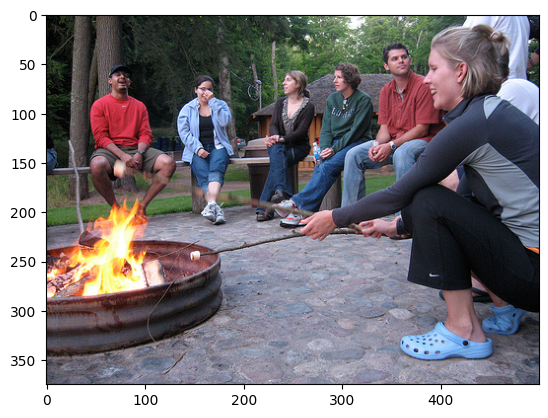

Caption:  a group of people are gathered around a campfire .


In [30]:
# Chọn ảnh từ encoding_test với chỉ số z
z = 97
pic = list(encoding_test.keys())[z]
cation_real=list(test_map.values())[z]
print("ALL caption real: ",cation_real)
print(pic)
print(encoding_test[pic])
# Trích xuất đặc trưng của ảnh từ encoding_test và chuẩn hóa lại kích thước
image = encoding_test[pic].reshape((1, 2048))

# Đọc và hiển thị ảnh
x = plt.imread(images_dir + pic)
plt.imshow(x)
plt.show()

# Gọi hàm greedySearch để tạo chuỗi mô tả cho ảnh
caption = greedySearch(image)
print("Caption: ", caption)

**Đánh giá chỉ số Bleu trung bình trên tập test**

In [21]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Hàm tính các loại BLEU
def calculate_bleu(reference_captions, generated_caption):
    """
    reference_captions: Danh sách các câu mô tả thực tế cho ảnh.
    generated_caption: Chuỗi mô tả được sinh ra.
    """
    # Tokenize các mô tả
    references = [ref.split() for ref in reference_captions]
    candidate = generated_caption.split()
    # Smoothing function để tránh chia cho 0 khi BLEU = 0
    smoothie = SmoothingFunction().method4

    # Tính BLEU-1, BLEU-2, BLEU-3, BLEU-4
    bleu1 = sentence_bleu(references, candidate, weights=(1, 0, 0, 0), smoothing_function=smoothie)
    bleu2 = sentence_bleu(references, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu3 = sentence_bleu(references, candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu4 = sentence_bleu(references, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)
    return bleu1, bleu2, bleu3, bleu4

# Tính điểm BLEU trung bình cho tập test_map
bleu_scores = {"bleu1": [], "bleu2": [], "bleu3": [], "bleu4": []}

for idx, (image_name, reference_captions) in enumerate(test_map.items()):
    # Lấy đặc trưng ảnh từ encoding_test
    photo_feature = encoding_test[image_name].reshape((1, 2048))
    
    # Sinh chuỗi mô tả cho ảnh
    generated_caption = greedySearch(photo_feature)
    
    # Tính các chỉ số BLEU
    bleu1, bleu2, bleu3, bleu4 = calculate_bleu(reference_captions, generated_caption)
    bleu_scores["bleu1"].append(bleu1)
    bleu_scores["bleu2"].append(bleu2)
    bleu_scores["bleu3"].append(bleu3)
    bleu_scores["bleu4"].append(bleu4)

    # Hiển thị một số kết quả (tùy chọn)
    if idx < 5:  # Hiển thị 5 ảnh đầu tiên
        print(f"Ảnh: {image_name}")
        print(f"Mô tả thực tế: {reference_captions}")
        print(f"Mô tả sinh ra: {generated_caption}")
        print(f"BLEU-1: {bleu1:.4f}, BLEU-2: {bleu2:.4f}, BLEU-3: {bleu3:.4f}, BLEU-4: {bleu4:.4f}\n")

# Tính điểm BLEU trung bình
average_bleu1 = np.mean(bleu_scores["bleu1"])
average_bleu2 = np.mean(bleu_scores["bleu2"])
average_bleu3 = np.mean(bleu_scores["bleu3"])
average_bleu4 = np.mean(bleu_scores["bleu4"])

print(f"\nĐiểm BLEU trung bình trên tập test:")
print(f"BLEU-1: {average_bleu1:.4f}")
print(f"BLEU-2: {average_bleu2:.4f}")
print(f"BLEU-3: {average_bleu3:.4f}")
print(f"BLEU-4: {average_bleu4:.4f}")


Ảnh: 868984478.jpg
Mô tả thực tế: ['start a young woman wearing shorts and a tank top is sitting on an outdoor swing . end', 'start happily , a young woman tries out her new oversized rope swing . end', 'start a young smiling woman is having fun on a rustic looking swing . end', 'start a young woman on a rope and plank swing in an outdoor setting . end', 'start a happy girl swings on her porch . end']
Mô tả sinh ra: a woman in a white dress is sitting on a swing .
BLEU-1: 0.7500, BLEU-2: 0.5222, BLEU-3: 0.3046, BLEU-4: 0.2716

Ảnh: 86901941.jpg
Mô tả thực tế: ['start this gentleman is working at his bench with the comfort of his cat nearby and a thermos at the ready . end', 'start a man with a colorful hat is sitting next to a variety of tools . end', 'start a old man sells hardware parts on a dirty sidewalk . end', 'start a man is sitting against a building using tools . end', 'start man sitting on a can in the street . end']
Mô tả sinh ra: a man in a white shirt is working on a rock 

In [18]:
from nltk.stem.porter import PorterStemmer
from nltk.translate.bleu_score import SmoothingFunction
from collections import Counter
import numpy as np

# Hàm tính METEOR
def calculate_meteor_manual(reference_captions, generated_caption):
    """
    reference_captions: Danh sách các mô tả thực tế (list).
    generated_caption: Chuỗi mô tả được sinh ra (string).
    """
    stemmer = PorterStemmer()
    
    # Tokenize và chuẩn hóa các từ
    def normalize(sentence):
        return [stemmer.stem(word.lower()) for word in sentence.split()]
    
    # Tính precision, recall
    generated_tokens = normalize(generated_caption)
    reference_tokens = [normalize(ref) for ref in reference_captions]
    
    matches = Counter(generated_tokens)
    for ref in reference_tokens:
        matches &= Counter(ref)
    
    match_count = sum(matches.values())
    precision = match_count / len(generated_tokens) if generated_tokens else 0
    recall = match_count / max(len(ref) for ref in reference_tokens) if reference_tokens else 0
    
    # F-Measure
    if precision + recall > 0:
        f_score = 10 * precision * recall / (9 * precision + recall)
    else:
        f_score = 0
    return f_score

# Sử dụng trên tập test_map
meteor_scores = []
for idx, (image_name, reference_captions) in enumerate(test_map.items()):
    photo_feature = encoding_test[image_name].reshape((1, 2048))
    generated_caption = greedySearch(photo_feature)
    meteor = calculate_meteor_manual(reference_captions, generated_caption)
    meteor_scores.append(meteor)
    if idx < 5:  # Hiển thị 5 kết quả đầu
        print(f"Ảnh: {image_name}")
        print(f"Mô tả tham chiếu: {reference_captions}")
        print(f"Mô tả sinh: {generated_caption}")
        print(f"METEOR: {meteor:.4f}\n")

average_meteor = np.mean(meteor_scores)
print(f"Điểm METEOR trung bình: {average_meteor:.4f}")


Ảnh: 868984478.jpg
Mô tả tham chiếu: ['start a young woman wearing shorts and a tank top is sitting on an outdoor swing . end', 'start happily , a young woman tries out her new oversized rope swing . end', 'start a young smiling woman is having fun on a rustic looking swing . end', 'start a young woman on a rope and plank swing in an outdoor setting . end', 'start a happy girl swings on her porch . end']
Mô tả sinh: a woman in a white dress is sitting on a swing .
METEOR: 0.1724

Ảnh: 86901941.jpg
Mô tả tham chiếu: ['start this gentleman is working at his bench with the comfort of his cat nearby and a thermos at the ready . end', 'start a man with a colorful hat is sitting next to a variety of tools . end', 'start a old man sells hardware parts on a dirty sidewalk . end', 'start a man is sitting against a building using tools . end', 'start man sitting on a can in the street . end']
Mô tả sinh: a man in a white shirt is working on a rock .
METEOR: 0.0913

Ảnh: 86987116.jpg
Mô tả tham c

**Test với một ảnh bất kỳ , load mô hình lên**

In [ ]:
# import numpy as np
# from keras.preprocessing import image
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
# from keras.models import load_model
# from keras.preprocessing.sequence import pad_sequences
# import pickle
# import matplotlib.pyplot as plt

# # Định nghĩa hàm tiền xử lý ảnh
# def preprocess(image_path):
#     img = image.load_img(image_path, target_size=(299, 299))  # Resize về kích thước 299x299
#     x = image.img_to_array(img)  # Chuyển ảnh thành mảng numpy
#     x = np.expand_dims(x, axis=0)  # Thêm một chiều cho batch
#     x = preprocess_input(x)  # Tiền xử lý ảnh theo yêu cầu của InceptionV3
#     return x

# # Tải mô hình InceptionV3 (đã loại bỏ lớp cuối)
# model_new = load_model('/kaggle/working/inception_v3_feature_extractor.h5')

# # Định nghĩa hàm trích xuất đặc trưng ảnh
# def encode(image_path):
#     image = preprocess(image_path)  # Tiền xử lý ảnh
#     feature_vector = model_new.predict(image, verbose=0)  # Lấy đặc trưng ảnh
#     feature_vector = np.reshape(feature_vector, feature_vector.shape[1])  # Đổi hình dạng thành (2048, )
#     return feature_vector

# # Tải mô hình captioning đã huấn luyện
# model = load_model('/kaggle/working/model_images_captioning.h5')

# # Tải các từ điển
# with open('/kaggle/working/Pickle/wordtoix.pkl', 'rb') as f:
#     wordtoix = pickle.load(f)
# with open('/kaggle/working/Pickle/ixtoword.pkl', 'rb') as f:
#     ixtoword = pickle.load(f)

# # Hàm tìm kiếm bằng phương pháp greedy (dự đoán chuỗi mô tả)
# def greedySearch(photo):
#     in_text = 'start'
#     for i in range(max_length):
#         sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
#         sequence = pad_sequences([sequence], maxlen=max_length)
#         yhat = model.predict([photo, sequence], verbose=0)
#         yhat = np.argmax(yhat)
#         word = ixtoword[yhat]
#         in_text += ' ' + word
#         if word == 'end':
#             break
#     final = in_text.split()
#     final = final[1:-1]  # Bỏ 'startseq' và 'endseq'
#     final = ' '.join(final)
#     return final

In [ ]:
# # Chọn ảnh cần test
# img_path = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1000092795.jpg'  # Đặt đường dẫn tới ảnh cần test

# # Trích xuất đặc trưng ảnh
# image_encoding = encode(img_path).reshape((1, 2048))
# # Hiển thị ảnh
# img = plt.imread(img_path)
# plt.imshow(img)
# plt.axis('off')
# plt.show()

# # Dự đoán caption cho ảnh
# caption = greedySearch(image_encoding)
# print("Caption: ", caption)
